# Building systematics maps for 3x2pt with Spark

<br>Kernel: desc-pyspark
<br>Owner: **S Plaszczynski** 
<br>Last Verified to Run: **2019-01-10**

The goal of this notebook is to show how to build (simply) Healpix maps from the DC2 
DPDD output inorder to test for possible 3x2pt systematics.
It is illustrated on the current run1.2p production.
It also shows how Spark can be used for data analysis (for more details see: https://arxiv.org/abs/1807.03078)
Note that the full power of Spark will reveal when more data will be available.

The advantages of using Spark are:
- one can put the relevant variables in cache
- computation automatically optimised (lazy evaluation)
- the analysis will scale when more data will be available
- Spark is available at NERSC (as this notebook shows). jupyter-dev is limited to running on 4 threads ie 8GB mem. For (much) more memory use the interactive or batch mode, see https://github.com/LSSTDESC/desc-spark


# reading the data

In [12]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()
print("spark session started")

#usefull tool to benchmark
from time import time
class Timer:
    """
    a simple class for printing time (s) since last call
    """
    def __init__(self):
        self.t0=time()
    
    def start(self):
        self.t0=time()
        
    def stop(self):
        t1=time()
        print("{:2.1f}s".format(t1-self.t0))

timer=Timer()

spark session started


In [13]:
timer.start()
df_all=spark.read.parquet("/global/cscratch1/sd/plaszczy/Run1.2p/object_catalog/full_catalog.parquet")
df_all.printSchema()
timer.stop()

root
 |-- xErr: float (nullable = true)
 |-- magerr_z_cModel: double (nullable = true)
 |-- magerr_i_cModel: double (nullable = true)
 |-- Iyy_g: double (nullable = true)
 |-- snr_i_cModel: double (nullable = true)
 |-- Ixy_y: double (nullable = true)
 |-- mag_g: double (nullable = true)
 |-- Iyy_i: double (nullable = true)
 |-- objectId: long (nullable = true)
 |-- snr_r_cModel: double (nullable = true)
 |-- Iyy_u: double (nullable = true)
 |-- Ixy_r: double (nullable = true)
 |-- Ixx: double (nullable = true)
 |-- IxxPSF_g: double (nullable = true)
 |-- mag_z: double (nullable = true)
 |-- tract: long (nullable = true)
 |-- Iyy_z: double (nullable = true)
 |-- good: boolean (nullable = true)
 |-- mag_y: double (nullable = true)
 |-- psFlux_flag_i: boolean (nullable = true)
 |-- Ixy_z: double (nullable = true)
 |-- clean: boolean (nullable = true)
 |-- IyyPSF_u: double (nullable = true)
 |-- Ixx_z: double (nullable = true)
 |-- mag_r: double (nullable = true)
 |-- Ixx_y: double (nulla

select interesting columns (for this example we will only use the i band)

In [14]:
# build selection by appending to string
cols=["ra","dec","good","clean","extendedness","blendedness","mag_i_cModel","magerr_i_cModel","snr_i_cModel",\
      "psf_fwhm_i","Ixx_i","Iyy_i","Ixy_i","IxxPSF_i","IyyPSF_i","IxyPSF_i"]
print(cols)
#use these columns
df=df_all.select(cols)

['ra', 'dec', 'good', 'clean', 'extendedness', 'blendedness', 'mag_i_cModel', 'magerr_i_cModel', 'snr_i_cModel', 'psf_fwhm_i', 'Ixx_i', 'Iyy_i', 'Ixy_i', 'IxxPSF_i', 'IyyPSF_i', 'IxyPSF_i']


Apply some quality cuts

In [15]:
df=df.filter( (df.good==True)& \
            (df.clean==True) & \
             (df.extendedness>0.9) & \
             (df.blendedness < 10**(-0.375)) &\
            (df.mag_i_cModel< 24.5) &\
             (df.snr_i_cModel>10))

Add a column of healpixels (mapReduce way)

In [16]:
import pandas as pd
import numpy as np
import healpy as hp
from pyspark.sql.functions import pandas_udf, PandasUDFType

nside=2048
#create the ang2pix user-defined-function. 
#we use pandas_udf because they are more efficient
@pandas_udf('int', PandasUDFType.SCALAR)
def Ang2Pix(ra,dec):
    return pd.Series(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra)))

#add a column of healpix indices
df=df.withColumn("ipix",Ang2Pix("ra","dec"))
#groupby indices and count the number of elements in each group
df_map=df.groupBy("ipix").count()

Drop all Nans and put in cache

In [17]:
timer.start()
df.na.drop().cache()
print("sample has {}M objects".format(df.count()/1e6))
timer.stop()

sample has 1.026842M objects
2.6s


## Mean counts

In [18]:
timer.start()
#groupby indices and count the number of elements in each group
df_map=df.groupBy("ipix").count()
#statistics per pixel
df_map.describe(['count']).show() 
#back to python world
map_p=df_map.toPandas()
#now data is reduced create the healpy map
map_c = np.zeros(hp.nside2npix(nside))
map_c[map_p['ipix'].values]=map_p['count'].values
#map_c[map_c==0]=hp.UNSEEN
timer.stop()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|             34445|
|   mean| 29.81106111191755|
| stddev|13.829903847822989|
|    min|                 1|
|    max|               106|
+-------+------------------+

8.7s


<Figure size 432x288 with 0 Axes>

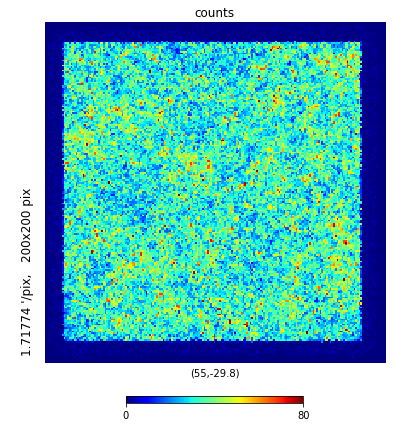

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet')
hp.gnomview(map_c,rot=[55,-29.8],reso=hp.nside2resol(nside,arcmin=True),max=80,title='counts')

## Sky sigma

+-------+--------------------+
|summary|avg(magerr_i_cModel)|
+-------+--------------------+
|  count|               34445|
|   mean|0.024500885427180673|
| stddev|0.012347323648925776|
|    min|2.134098291166544E-4|
|    max|  0.1084740582290262|
+-------+--------------------+



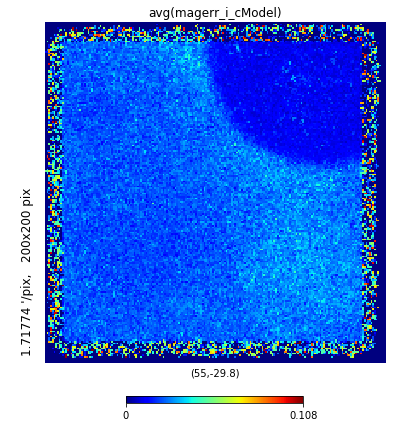

In [20]:
var="magerr_i_cModel"
var_sys="avg("+var+")"
df_map=df.groupBy("ipix").mean(var)
df_map.describe([var_sys]).show() 
dfp=df_map.toPandas()
map_s = np.zeros(hp.nside2npix(nside))
map_s[dfp['ipix'].values]=dfp[var_sys].values
hp.gnomview(map_s,rot=[55,-29.8],reso=hp.nside2resol(nside,arcmin=True),title=var_sys)

+-------+------------------+
|summary| avg(snr_i_cModel)|
+-------+------------------+
|  count|             34445|
|   mean|164.15670419096477|
| stddev|169.24539569737587|
|    min|10.009178438459132|
|    max| 5087.564191641063|
+-------+------------------+



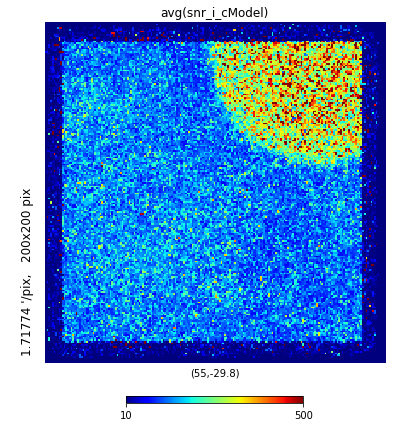

In [21]:
var='snr_i_cModel'
var_sys="avg("+var+")"
df_map=df.groupBy("ipix").mean(var)
df_map.describe([var_sys]).show() 
dfp=df_map.toPandas()
map_s = np.zeros(hp.nside2npix(nside))
map_s[dfp['ipix'].values]=dfp[var_sys].values
hp.gnomview(map_s,rot=[55,-29.8],reso=hp.nside2resol(nside,arcmin=True),min=10,max=500,title=var_sys)

## Mean seeing

+-------+-------------------+
|summary|    avg(psf_fwhm_i)|
+-------+-------------------+
|  count|              34445|
|   mean| 0.7585912225874618|
| stddev|0.02875550973296599|
|    min| 0.4634907660683619|
|    max| 1.2366712329163176|
+-------+-------------------+



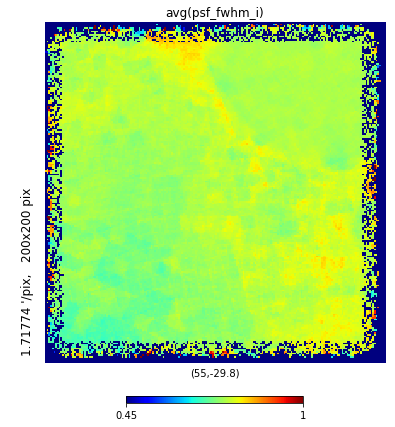

In [22]:
var="psf_fwhm_i"
var_sys="avg("+var+")"
df_map=df.groupBy("ipix").mean(var)
df_map.describe([var_sys]).show() 
dfp=df_map.toPandas()
map_s = np.zeros(hp.nside2npix(nside))
map_s[dfp['ipix'].values]=dfp[var_sys].values
hp.gnomview(map_s,rot=[55,-29.8],reso=hp.nside2resol(nside,arcmin=True),min=0.45,max=1.,title=var_sys)

## Ellipticities 


compute distorsion (thanks to Javier). Note that we don't have redshifts

### Signal

In [61]:
from pyspark.sql import functions as F
Q11="IxxPSF_i"
Q22="IyyPSF_i"
Q12="IxyPSF_i"

# pre-compute denominator
df_shear=df.withColumn("denom",F.col(Q11)+F.col(Q22))
#read and img parts of shear
df_shear=df_shear.withColumn("R_E",(F.col(Q11)-F.col(Q22))/F.col('denom')).\
        withColumn("I_E",(2*F.col(Q12))/F.col('denom'))
# convert to amplitude and phase
df_shear=df_shear.withColumn("amp_E",F.hypot(F.col("R_E"),F.col("I_E"))).\
    withColumn("phase_E",F.atan2(F.col("R_E"),F.col("I_E")))
df_shear.select("R_E","I_E","amp_E","phase_E").show(5)

+--------------------+--------------------+--------------------+-------------------+
|                 R_E|                 I_E|               amp_E|            phase_E|
+--------------------+--------------------+--------------------+-------------------+
|0.007246182544069873| 0.01418021293385543| 0.01592437126895325| 0.4724140760070876|
|0.003568535569388947|0.014762145616105947| 0.01518734306260019| 0.2371853715455586|
| 0.00869009643549297|0.013290660532789492| 0.01587952875421736| 0.5790768606800847|
|0.003478605225655...|0.014664918534131778|0.015071845604592769|0.23290138725901982|
|0.007994816523823053| 0.01396278968083379|0.016089642224760396| 0.5200138136124188|
+--------------------+--------------------+--------------------+-------------------+
only showing top 5 rows



+-------+--------------------+
|summary|          avg(amp_E)|
+-------+--------------------+
|  count|               34445|
|   mean|0.017776996524925093|
| stddev|0.013070370158505245|
|    min|1.333122569798362E-4|
|    max| 0.22244359041872053|
+-------+--------------------+



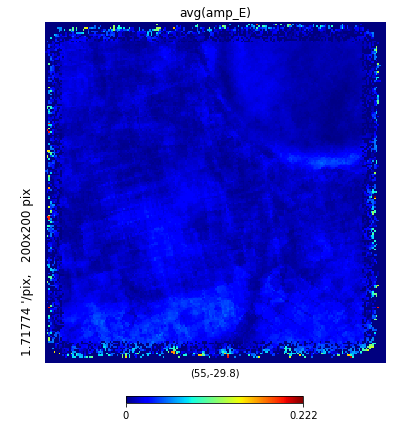

In [63]:
var="amp_E"
var_sys="avg("+var+")"
df_map=df_shear.groupBy("ipix").mean(var)
df_map.describe([var_sys]).show() 
dfp=df_map.toPandas()
map_e = np.zeros(hp.nside2npix(nside))
map_e[dfp['ipix'].values]=dfp[var_sys].values
hp.gnomview(map_e,rot=[55,-29.8],reso=hp.nside2resol(nside,arcmin=True),title=var_sys)

+-------+--------------------+
|summary|        avg(phase_E)|
+-------+--------------------+
|  count|               34440|
|   mean|0.007071566530390142|
| stddev|  0.6297128563006118|
|    min|  -3.139029564064607|
|    max|  3.1409622795373204|
+-------+--------------------+



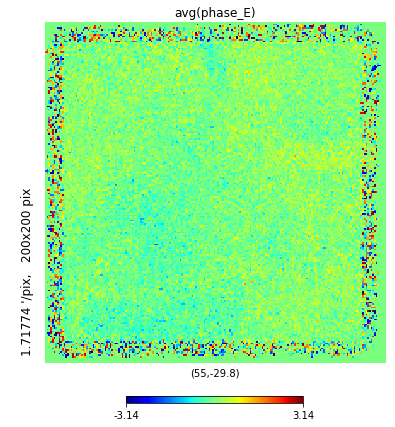

In [60]:
var="phase_E"
var_sys="avg("+var+")"
df_map=df_shear.groupBy("ipix").mean(var)
df_map.describe([var_sys]).show() 
dfp=df_map.toPandas()
map_e = np.zeros(hp.nside2npix(nside))
map_e[dfp['ipix'].values]=dfp[var_sys].values
hp.gnomview(map_e,rot=[55,-29.8],reso=hp.nside2resol(nside,arcmin=True),title=var_sys)

# Missing quantities

- redshift 
- airmass
- HSM _e1/e2 (ext_shapeHSM_HsmShapeRegauss_e1 and ext_shapeHSM_HsmShapeRegauss_e2 availbale in GCR as native_quantities but not DPDD)
- ?